# Chloe idea - [Issue #1](https://github.com/lucasbaldezzari/babesbayes-nma/issues/1)

> For each run ID> use prior mean & prior std to calculate the "range" for the run, the constraints on where the angle can appear > binary filter on the participants' response within that run (0= inside the "range", 1 = outside the "range") > raster plot over the time within the run to determine when participant learns the constraints of that particular run

---

In [1]:
##importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, requests
from numpy import pi
import seaborn as sns

from utils import getSubjecBasicStats

In [2]:
data = pd.read_csv("dataset\\data01_direction4priors.csv")
# data.head()

### Working with subject 6

In [3]:
subject_id = 6

data_s6 = data.loc[data['subject_id'] == subject_id]

In [4]:
# data_s6.info()
data_s6.describe()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_id,session_id,run_id
count,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.0,7553.0,7553.0,7553.000000,7553.000000
mean,108.661724,309.325031,179.981067,216.992586,0.110936,-1.045612,-0.946761,1.333163,311.954266,46.830399,225.0,6.0,12.0,4.000000,18.007017
std,62.745776,180.027234,104.666585,57.608262,0.063919,1.347272,1.563893,0.359714,180.002593,29.726685,0.0,0.0,0.0,2.000132,10.098316
min,1.000000,0.000000,0.000000,5.000000,0.060000,-2.500000,-2.499999,0.226008,2.154724,10.000000,225.0,6.0,12.0,1.000000,1.000000
25%,54.000000,153.569935,87.000000,205.000000,0.060000,-2.067683,-2.190949,1.051133,156.578177,20.000000,225.0,6.0,12.0,2.000000,9.000000
50%,108.000000,309.394858,181.000000,225.000000,0.120000,-1.483085,-1.583259,1.274959,311.930449,40.000000,225.0,6.0,12.0,4.000000,18.000000
75%,162.000000,463.135354,272.000000,245.000000,0.120000,-0.396685,-0.012798,1.557451,465.658664,80.000000,225.0,6.0,12.0,6.000000,27.000000
max,226.000000,692.979736,359.000000,355.000000,0.240000,2.499999,2.499999,3.542557,695.325845,80.000000,225.0,6.0,12.0,7.000000,35.000000


### Creating ranges from reaction time

I will take the *reaction_time* column and make ranges from 0 to max value with steps of 0.25 seconds.

I will use [pandas.cut](https://pandas.pydata.org/docs/reference/api/pandas.cut.html)

In [5]:
ranges = np.arange(0, data_s6['reaction_time'].max(), 0.25)
ranges

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 ])

In [6]:
ranges = np.arange(0, data_s6['reaction_time'].max(), 0.25)
print("The ranges in secs are:")
print(*ranges)
data_s6.loc[:,'reaction_time_range'] = pd.cut(data_s6['reaction_time'], bins=ranges, labels=False)+1

The ranges in secs are:
0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 2.25 2.5 2.75 3.0 3.25 3.5


C:\Users\corre\AppData\Local\Temp\ipykernel_17604\313748483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_s6.loc[:,'reaction_time_range'] = pd.cut(data_s6['reaction_time'], bins=ranges, labels=False)+1


In [7]:
##counting the number of values in each range
data_s6.loc[:,'reaction_time_range'].value_counts().sort_index()

reaction_time_range
1.0        1
3.0       68
4.0     1349
5.0     2178
6.0     1735
7.0     1218
8.0      610
9.0      285
10.0      78
11.0      27
12.0       3
Name: count, dtype: int64

In [8]:
indexes = data_s6.loc[:,'reaction_time_range'].value_counts().sort_index().index.astype(int)
x_labels = ranges[indexes]
indexes


Index([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int32', name='reaction_time_range')

In [9]:
data_s6.loc[data_s6['reaction_time_range'].isin(indexes)]['reaction_time_range'].value_counts()

reaction_time_range
5.0     2178
6.0     1735
4.0     1349
7.0     1218
8.0      610
9.0      285
10.0      78
3.0       68
11.0      27
12.0       3
1.0        1
Name: count, dtype: int64

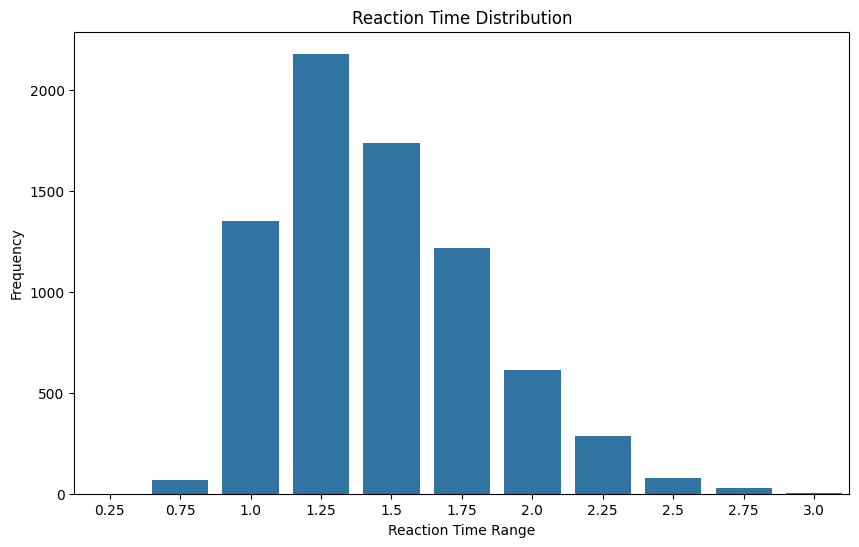

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data_s6.loc[data_s6['reaction_time_range'].isin(indexes)], x='reaction_time_range')
plt.title('Reaction Time Distribution')
plt.xlabel('Reaction Time Range')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=0)
plt.show()

### Getting angles from $x$ and $y$ coordinates

In [11]:
from utils import getAngles
x = data_s6['estimate_x'].values
y = data_s6['estimate_y'].values
##using estimate_x and estimate_y to calculate the angle
data_s6.loc[:,'estimate_angles'] = getAngles(x, y)
##limit the angles between 0 and 359 using %360
data_s6.loc[:,'estimate_angles'] = data_s6['estimate_angles'] % 360

C:\Users\corre\AppData\Local\Temp\ipykernel_17604\612046442.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_s6.loc[:,'estimate_angles'] = getAngles(x, y)


In [12]:
print(data_s6.loc[:,'estimate_angles'].max(), data_s6.loc[:,'estimate_angles'].min())

359.9596407503122 0.3680817241476178


In [13]:
data_s6.describe()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_id,session_id,run_id,reaction_time_range,estimate_angles
count,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.0,7553.0,7553.0,7553.000000,7553.000000,7552.000000,7553.000000
mean,108.661724,309.325031,179.981067,216.992586,0.110936,-1.045612,-0.946761,1.333163,311.954266,46.830399,225.0,6.0,12.0,4.000000,18.007017,5.824285,207.073506
std,62.745776,180.027234,104.666585,57.608262,0.063919,1.347272,1.563893,0.359714,180.002593,29.726685,0.0,0.0,0.0,2.000132,10.098316,1.466160,67.759132
min,1.000000,0.000000,0.000000,5.000000,0.060000,-2.500000,-2.499999,0.226008,2.154724,10.000000,225.0,6.0,12.0,1.000000,1.000000,1.000000,0.368082
25%,54.000000,153.569935,87.000000,205.000000,0.060000,-2.067683,-2.190949,1.051133,156.578177,20.000000,225.0,6.0,12.0,2.000000,9.000000,5.000000,180.372030
50%,108.000000,309.394858,181.000000,225.000000,0.120000,-1.483085,-1.583259,1.274959,311.930449,40.000000,225.0,6.0,12.0,4.000000,18.000000,6.000000,221.624991
75%,162.000000,463.135354,272.000000,245.000000,0.120000,-0.396685,-0.012798,1.557451,465.658664,80.000000,225.0,6.0,12.0,6.000000,27.000000,7.000000,247.041329
max,226.000000,692.979736,359.000000,355.000000,0.240000,2.499999,2.499999,3.542557,695.325845,80.000000,225.0,6.0,12.0,7.000000,35.000000,12.000000,359.959641


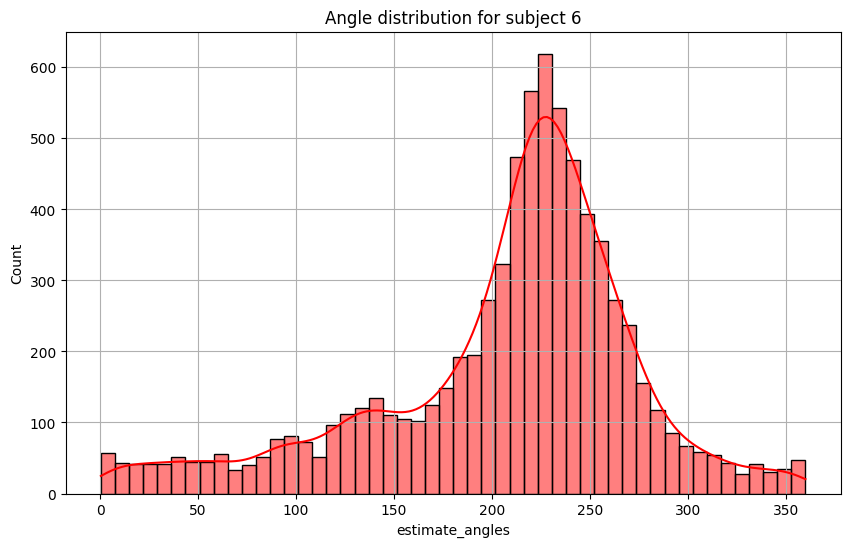

In [14]:
##plotting angle distribution
plt.figure(figsize=(10,6))
sns.histplot(data_s6['estimate_angles'], bins=50, kde=True, color='r', alpha=0.5)
plt.title('Angle distribution for subject 6')
plt.grid()
plt.show()

#### Making a new column from difference the motion_direction and estimate_angles 

In [15]:
# Making a new column from difference the motion_direction and estimate_angles 
data_s6.loc[:,'diff_angles'] = data_s6['motion_direction'] - data_s6['estimate_angles']
data_s6.loc[:,'diff_angles'].describe()

C:\Users\corre\AppData\Local\Temp\ipykernel_17604\1168774008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_s6.loc[:,'diff_angles'] = data_s6['motion_direction'] - data_s6['estimate_angles']


count    7553.000000
mean        9.919080
std        67.752337
min      -354.278497
25%       -18.130914
50%         1.472490
75%        22.627970
max       353.721503
Name: diff_angles, dtype: float64

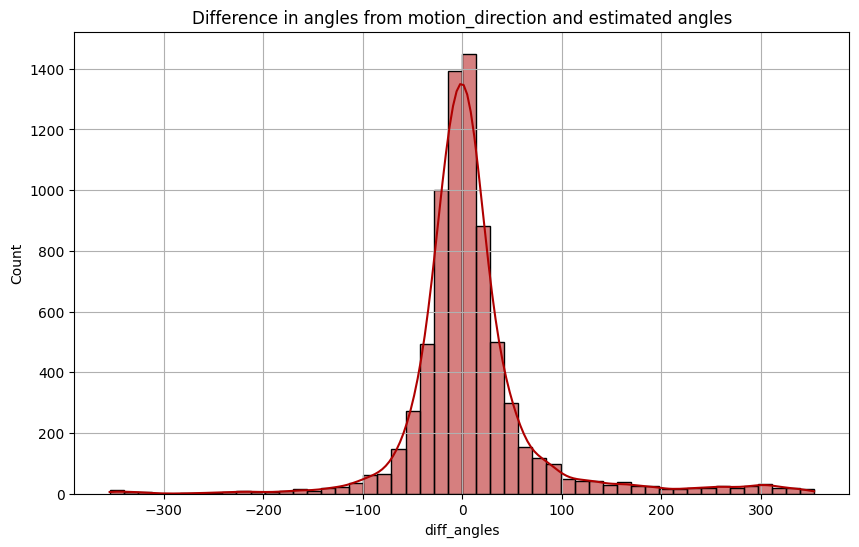

In [16]:
##plotting angle distribution
plt.figure(figsize=(10,6))
sns.histplot(data_s6['diff_angles'], bins=50, kde=True, color='#af0000', alpha=0.5)
plt.title('Difference in angles from motion_direction and estimated angles')
plt.grid()
plt.show()